In [1]:


!pip install pmdarima
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
import matplotlib.ticker as ticker
from matplotlib import font_manager, rc
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import aic, bic
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

In [2]:
cow_df = pd.read_csv("2013~2023 OASIS 한우 도매가격.csv")

In [3]:
cow_df.head()

,경락일자,1++,1+,1,2,3,A,B,C
0,13-Jan,17796.13493,15897.03218,14498.31766,11898.240010,9604.434475,14560.86619,14133.81072,13724.01001
1,13-Feb,17323.02930,15050.83944,13396.67663,11008.405170,8813.603044,13450.41811,13118.29575,12677.61560
2,13-Mar,17391.77210,14606.46355,12914.19227,10634.521040,8690.506928,13127.20544,12651.69120,12290.21430
3,13-Apr,17730.51938,14696.78851,12780.23766,10471.542610,8528.058779,13051.72209,12632.64493,12201.71725
4,13-May,17044.26705,13999.76299,12340.69142,9842.388201,7555.239542,12544.30475,12006.72247,11433.58866


In [4]:
# '경락일자'에서 년도와 월을 분리
cow_df['년도'] = '20' + cow_df['경락일자'].str.split('-').str[0]

# 월 이름을 숫자로 매핑
month_map = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}
cow_df['월'] = cow_df['경락일자'].str.split('-').str[1].map(month_map)

C:\Users\jaesu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jaesu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jaesu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46321 (\N{HANGUL SYLLABLE DEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jaesu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jaesu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jaesu\anacon

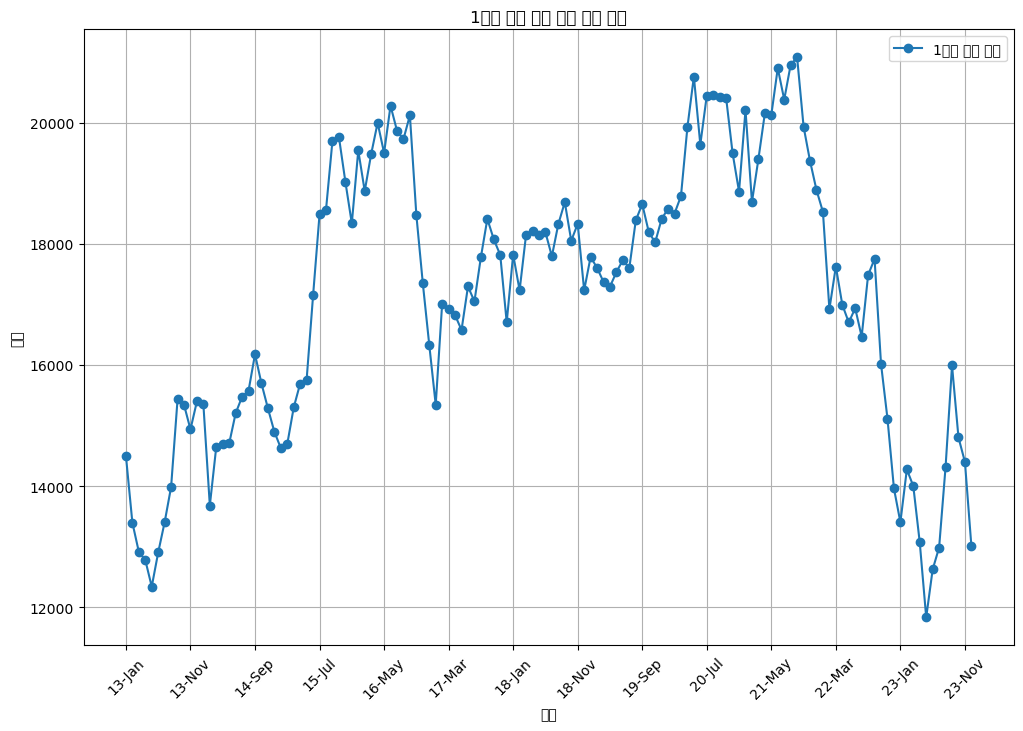

In [5]:
# 전체 기간의 1등급 한우 가격 추이 그래프 그리기
plt.figure(figsize=(12, 8))
plt.plot(cow_df['경락일자'], cow_df['1'], marker='o', label='1등급 한우 가격')

plt.title('1등급 한우 가격 전체 기간 추이')
plt.xlabel('날짜')
plt.ylabel('가격')

# x축 간격 조절 및 레이블 회전
plt.xticks(cow_df['경락일자'][::10], rotation=45)  # [::1]를 [::n]으로 변경하여 표시 간격 조절 가능
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# ADF 검정 수행
adf_test = adfuller(cow_df['1'].dropna())

# 결과 출력
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

for key, value in adf_test[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -3.038655098634623
p-value: 0.03143881628490439
Critical Values 1%: -3.4870216863700767
Critical Values 5%: -2.8863625166643136
Critical Values 10%: -2.580009026141913


<Figure size 1200x600 with 0 Axes>

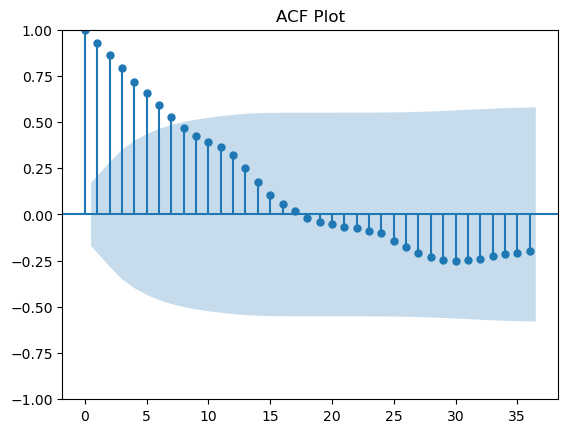

In [7]:
# ACF 플롯
plt.figure(figsize=(12, 6))
plot_acf(cow_df['1'], lags=36)
plt.title('ACF Plot')
plt.show()

<Figure size 1200x600 with 0 Axes>

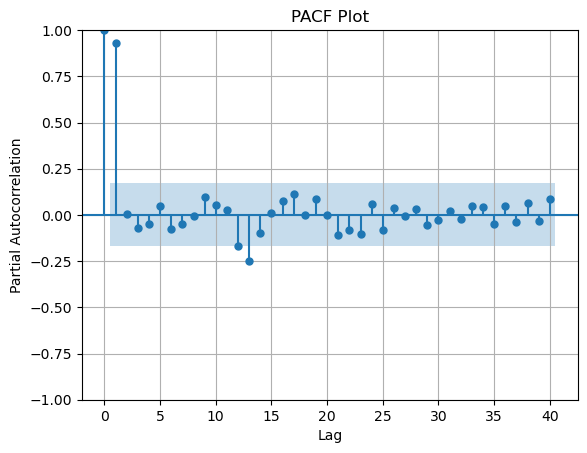

In [8]:
# PACF 플롯
plt.figure(figsize=(12, 6))
plot_pacf(cow_df['1'], lags=40)
plt.title('PACF Plot')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

In [9]:
# 일반 차분은 진행하지 않고, 계절차분만 고려해서 진행

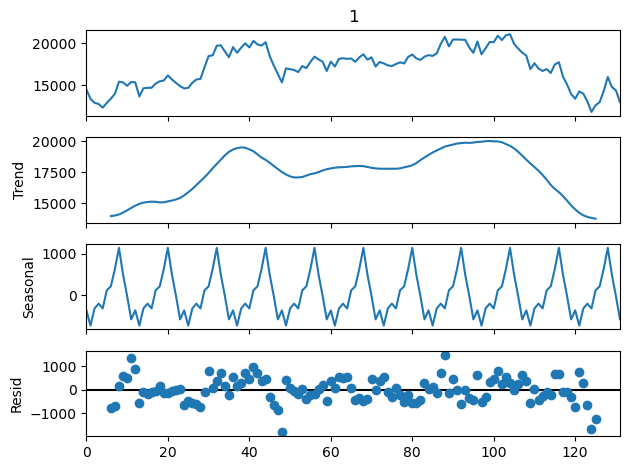

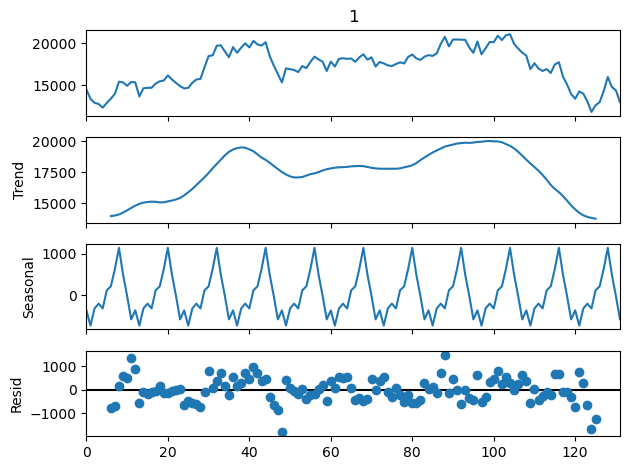

In [10]:
result = seasonal_decompose(cow_df['1'], model='additive', period=12)
result.plot()

In [11]:
# 추세, 잔차를 빼고 계절적 요소만을 봤을 때, 1등급 한우 도매가격에는 계절성이 있다고 판단할 수 있었다.

In [27]:
differenced = cow_df['1'].diff(12).dropna()

print(differenced)

12      852.15711
13      282.82965
14     1736.42959
15     1922.46045
16     2363.28976
          ...    
127   -3169.93587
128   -1757.43695
129   -1213.25605
130    -714.04651
131    -953.17744
Name: 1, Length: 120, dtype: float64


<Figure size 1200x600 with 0 Axes>

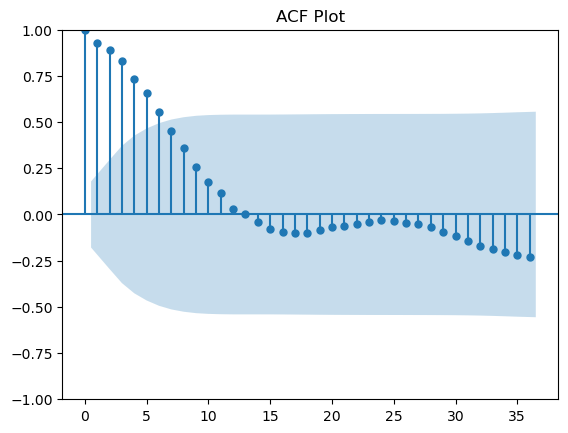

In [29]:
# ACF 플롯
plt.figure(figsize=(12, 6))
plot_acf(differenced, lags=36)
plt.title('ACF Plot')
plt.show()

In [20]:
p = q = range(0, 3)
P = Q = range(0, 3)
D = 1  # 계절 차분 차수 D=1로 고정
m = 12  # 계절 주기

# 가능한 모든 파라미터 조합을 생성합니다. 여기서 d=0으로 고정합니다.
pdq = [(x[0], 0, x[1]) for x in itertools.product(p, q)]
seasonal_pdq = [(x[0], D, x[1], m) for x in itertools.product(P, Q)]

aic_results = []
best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

# 모든 파라미터 조합에 대해 SARIMA 모델을 피팅하고 AIC를 계산합니다.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(cow_df['1'],
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            aic_results.append((param, param_seasonal, results.aic))
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
                best_model = results
                
        except Exception as e:
            continue

# 최적의 모델 파라미터와 AIC를 출력합니다.
print('Best SARIMA model order {} seasonal_order {} - AIC:{}'.format(best_order, best_seasonal_order, best_aic))

# 최적 모델의 요약 출력
print(best_model.summary())

C:\Users\jaesu\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jaesu\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jaesu\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jaesu\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jaesu\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

Best SARIMA model order (1, 0, 2) seasonal_order (0, 1, 2, 12) - AIC:1492.752896340552
                                     SARIMAX Results                                      
Dep. Variable:                                  1   No. Observations:                  132
Model:             SARIMAX(1, 0, 2)x(0, 1, 2, 12)   Log Likelihood                -740.376
Date:                            Tue, 03 Sep 2024   AIC                           1492.753
Time:                                    11:56:17   BIC                           1507.948
Sample:                                         0   HQIC                          1498.888
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9431      

C:\Users\jaesu\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
# 청탁 금지법
cow_df['년도'] = pd.to_numeric(cow_df['년도'], errors='coerce')
cow_df['월'] = pd.to_numeric(cow_df['월'], errors='coerce')
# 새로운 더미 변수 생성 (2016년 9월 이후는 1, 나머지는 0)
cow_df['SD_dummy'] = ((cow_df['년도'] > 2016) | ((cow_df['년도'] == 2016) & (cow_df['월'] >= 9))).astype(int)

# 데이터프레임의 '년도'와 '월' 열을 int로 변환
cow_df['년도'] = cow_df['년도'].astype(int)
cow_df['월'] = cow_df['월'].astype(int)

# 등급제 개편 더미 변수 추가
# 2019년 12월 이후부터 1로 설정, 그 이전은 0으로 설정
cow_df['Grade_Reform_dummy'] = cow_df.apply(lambda row: 1 if (row['년도'] > 2019 or (row['년도'] == 2019 and row['월'] >= 12)) else 0, axis=1)

# 결과 확인
print(cow_df[['경락일자', '년도', '월', 'Grade_Reform_dummy']].head(50))  # 상위 50개 데이터 확인

# 더미변수 생성
# 코로나19
years_of_interest = [2020, 2021, 2022]
cow_df['covid_dummy'] = cow_df['년도'].apply(lambda x: 1 if x in years_of_interest else 0)

# 구제역
# 새로운 더미 변수 초기화 (모두 0으로 설정)
cow_df['FMD_dummy'] = 0
cow_df.loc[((cow_df['년도'] == 2014) & (cow_df['월'] >= 9)) | ((cow_df['년도'] == 2015) & (cow_df['월'] <= 4)), 'FMD_dummy'] = 1


      경락일자    년도   월  Grade_Reform_dummy
0   13-Jan  2013   1                   0
1   13-Feb  2013   2                   0
2   13-Mar  2013   3                   0
3   13-Apr  2013   4                   0
4   13-May  2013   5                   0
5   13-Jun  2013   6                   0
6   13-Jul  2013   7                   0
7   13-Aug  2013   8                   0
8   13-Sep  2013   9                   0
9   13-Oct  2013  10                   0
10  13-Nov  2013  11                   0
11  13-Dec  2013  12                   0
12  14-Jan  2014   1                   0
13  14-Feb  2014   2                   0
14  14-Mar  2014   3                   0
15  14-Apr  2014   4                   0
16  14-May  2014   5                   0
17  14-Jun  2014   6                   0
18  14-Jul  2014   7                   0
19  14-Aug  2014   8                   0
20  14-Sep  2014   9                   0
21  14-Oct  2014  10                   0
22  14-Nov  2014  11                   0
23  14-Dec  2014

In [24]:
cow_df.head()

,경락일자,1++,1+,1,2,3,A,B,C,년도,월,SD_dummy,Grade_Reform_dummy,covid_dummy,FMD_dummy
0,13-Jan,17796.13493,15897.03218,14498.31766,11898.240010,9604.434475,14560.86619,14133.81072,13724.01001,2013,1,0,0,0,0
1,13-Feb,17323.02930,15050.83944,13396.67663,11008.405170,8813.603044,13450.41811,13118.29575,12677.61560,2013,2,0,0,0,0
2,13-Mar,17391.77210,14606.46355,12914.19227,10634.521040,8690.506928,13127.20544,12651.69120,12290.21430,2013,3,0,0,0,0
3,13-Apr,17730.51938,14696.78851,12780.23766,10471.542610,8528.058779,13051.72209,12632.64493,12201.71725,2013,4,0,0,0,0
4,13-May,17044.26705,13999.76299,12340.69142,9842.388201,7555.239542,12544.30475,12006.72247,11433.58866,2013,5,0,0,0,0


In [47]:
p = q = range(0, 3)
P = Q = range(0, 3)
D = 1  # 계절 차분 차수 D=1로 고정
m = 12  # 계절 주기

# 가능한 모든 파라미터 조합을 생성합니다. 여기서 d=0으로 고정합니다.
pdq = [(x[0], 0, x[1]) for x in itertools.product(p, q)]
seasonal_pdq = [(x[0], D, x[1], m) for x in itertools.product(P, Q)]
exog = cow_df[['SD_dummy','Grade_Reform_dummy','covid_dummy','FMD_dummy']]  # 원래 길이 유지

aic_results = []
best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

# 모든 파라미터 조합에 대해 SARIMA 모델을 피팅하고 AIC를 계산합니다.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(cow_df['1'],
                            order=param,
                            seasonal_order=param_seasonal,
                            exog=exog,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            aic_results.append((param, param_seasonal, results.aic))
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
                best_model = results
                
        except Exception as e:
            print(f"Error with parameters {param} and {param_seasonal}: {e}")
            continue

# 최적의 모델 파라미터와 AIC를 출력합니다.
if best_model is not None:
    print('Best SARIMA model order {} seasonal_order {} - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    print(best_model.summary())
else:
    print("No suitable model was found.")

C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 

Best SARIMA model order (1, 0, 2) seasonal_order (0, 1, 2, 12) - AIC:1528.518399152687
                                     SARIMAX Results                                      
Dep. Variable:                                  1   No. Observations:                  132
Model:             SARIMAX(1, 0, 2)x(0, 1, 2, 12)   Log Likelihood                -754.259
Date:                            Thu, 22 Aug 2024   AIC                           1528.518
Time:                                    12:21:57   BIC                           1553.844
Sample:                                         0   HQIC                          1538.744
                                            - 132                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
SD_dummy   

C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [49]:
p = q = range(0, 3)
P = Q = range(0, 3)
D = 1  # 계절 차분 차수 D=1로 고정
m = 12  # 계절 주기

# 가능한 모든 파라미터 조합을 생성합니다. 여기서 d=0으로 고정합니다.
pdq = [(x[0], 0, x[1]) for x in itertools.product(p, q)]
seasonal_pdq = [(x[0], D, x[1], m) for x in itertools.product(P, Q)]
exog = cow_df[['SD_dummy','covid_dummy','FMD_dummy']]  # 원래 길이 유지

aic_results = []
best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

# 모든 파라미터 조합에 대해 SARIMA 모델을 피팅하고 AIC를 계산합니다.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(cow_df['1'],
                            order=param,
                            seasonal_order=param_seasonal,
                            exog=exog,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            aic_results.append((param, param_seasonal, results.aic))
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
                best_model = results
                
        except Exception as e:
            print(f"Error with parameters {param} and {param_seasonal}: {e}")
            continue

# 최적의 모델 파라미터와 AIC를 출력합니다.
if best_model is not None:
    print('Best SARIMA model order {} seasonal_order {} - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    print(best_model.summary())
else:
    print("No suitable model was found.")

C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 

Best SARIMA model order (1, 0, 2) seasonal_order (0, 1, 2, 12) - AIC:1522.0200104057403
                                     SARIMAX Results                                      
Dep. Variable:                                  1   No. Observations:                  132
Model:             SARIMAX(1, 0, 2)x(0, 1, 2, 12)   Log Likelihood                -752.010
Date:                            Thu, 22 Aug 2024   AIC                           1522.020
Time:                                    12:24:54   BIC                           1544.813
Sample:                                         0   HQIC                          1531.223
                                            - 132                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
SD_dummy    -2233.3708  

C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [53]:
# 최종적으로 SARIMA (1,0,2)(0,1,2,12) 외생변수 3개로 모델 결정

In [89]:
# 이전에 선택된 최적의 SARIMA 모델 파라미터
order = (1, 0, 2)
seasonal_order = (0, 1, 2, 12)

# 모델 피팅
model = SARIMAX(cow_df['1'], 
                order=order, 
                seasonal_order=seasonal_order,
                exog=exog,
                enforce_stationarity=False, 
                enforce_invertibility=False)
results = model.fit()

# 요약 통계 출력
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  1   No. Observations:                  132
Model:             SARIMAX(1, 0, 2)x(0, 1, 2, 12)   Log Likelihood                -752.010
Date:                            Thu, 22 Aug 2024   AIC                           1522.020
Time:                                    14:11:15   BIC                           1544.813
Sample:                                         0   HQIC                          1531.223
                                            - 132                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
SD_dummy    -2233.3708    664.517     -3.361      0.001   -3535.800    -930.942
covid_dummy  2287.6208    350.92

C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [101]:
# 예측할 기간 설정 (예: 12개의 미래 데이터 포인트 예측)
n_periods = 12

# 예측에 사용할 외생변수 (예: 향후 n_periods 동안의 외생변수)
exog_future = exog.iloc[-n_periods:]  # 이 부분을 조정하여 미래 외생변수를 제공해야 함

# 예측 수행
forecast = results.get_forecast(steps=n_periods, exog=exog_future)
forecast_index = np.arange(len(cow_df['1']), len(cow_df['1']) + n_periods)

# 예측된 값 및 신뢰 구간 추출
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# 예측 인덱스를 2024년 1월부터 월 단위로 생성하고, 연도-월 형식으로 변환
forecast_index = pd.date_range(start='2024-01-01', periods=n_periods, freq='M').strftime('%Y-%m')

# 예측 값과 신뢰 구간에 인덱스 설정
forecast_values.index = forecast_index
forecast_conf_int.index = forecast_index

# 결과 출력
print("Forecasted Values:\n", forecast_values)
print("Confidence Intervals:\n", forecast_conf_int)

Forecasted Values:
 2024-01    13752.769296
2024-02    13766.177295
2024-03    14171.296632
2024-04    14259.645732
2024-05    13929.892920
2024-06    14469.303825
2024-07    14647.444137
2024-08    15279.888278
2024-09    16381.105079
2024-10    15667.374021
2024-11    15199.772119
2024-12    14504.360701
Name: predicted_mean, dtype: float64
Confidence Intervals:
               lower 1       upper 1
2024-01  12238.559513  15266.979078
2024-02  11910.006407  15622.348184
2024-03  12111.077244  16231.516019
2024-04  12034.666622  16484.624841
2024-05  11566.225423  16293.560416
2024-06  11987.444993  16951.162656
2024-07  12063.946322  17230.941953
2024-08  12608.320803  17951.455752
2024-09  13632.775161  19129.434997
2024-10  12851.821752  18482.926291
2024-11  12325.016189  18074.528049
2024-12  11577.148743  17431.572659


C:\Users\임재성\AppData\Local\Temp\ipykernel_12444\3823938322.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start='2024-01-01', periods=n_periods, freq='M').strftime('%Y-%m')


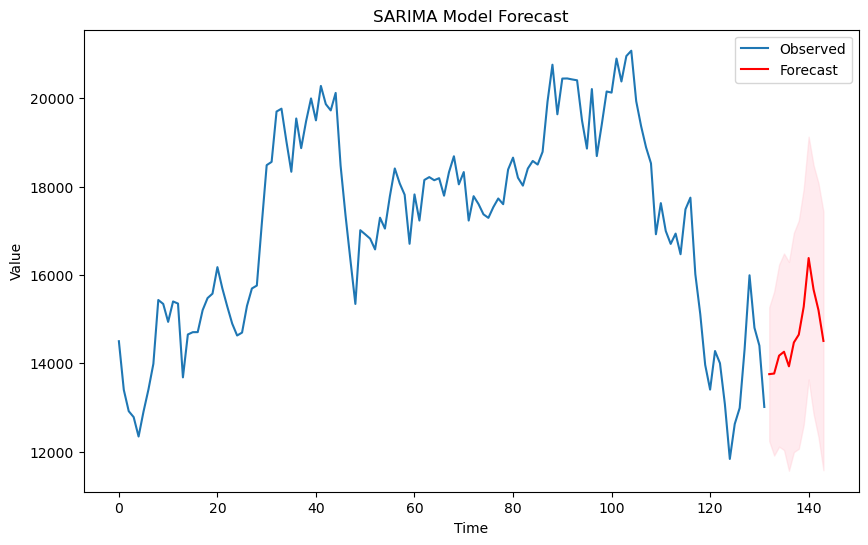

In [107]:
# 기존 데이터의 인덱스 길이를 기준으로 예측 인덱스 설정
forecast_index = np.arange(len(cow_df), len(cow_df) + len(forecast_values))

# 예측 값의 인덱스를 순차적인 숫자로 설정
forecast_values.index = forecast_index
forecast_conf_int.index = forecast_index

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(cow_df.index, cow_df['1'], label='Observed')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.title('SARIMA Model Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [85]:
p = q = range(0, 3)
P = Q = range(0, 3)
D = 1  # 계절 차분 차수 D=1로 고정
m = 12  # 계절 주기

# 가능한 모든 파라미터 조합을 생성합니다. 여기서 d=0으로 고정합니다.
pdq = [(x[0], 0, x[1]) for x in itertools.product(p, q)]
seasonal_pdq = [(x[0], D, x[1], m) for x in itertools.product(P, Q)]
exog2 = cow_df[['SD_dummy','covid_dummy']]  # 원래 길이 유지

aic_results = []
best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

# 모든 파라미터 조합에 대해 SARIMA 모델을 피팅하고 AIC를 계산합니다.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(cow_df['1'],
                            order=param,
                            seasonal_order=param_seasonal,
                            exog=exog2,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            aic_results.append((param, param_seasonal, results.aic))
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
                best_model = results
                
        except Exception as e:
            print(f"Error with parameters {param} and {param_seasonal}: {e}")
            continue

# 최적의 모델 파라미터와 AIC를 출력합니다.
if best_model is not None:
    print('Best SARIMA model order {} seasonal_order {} - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    print(best_model.summary())
else:
    print("No suitable model was found.")

C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 

Best SARIMA model order (1, 0, 2) seasonal_order (0, 1, 2, 12) - AIC:1515.9024047394303
                                     SARIMAX Results                                      
Dep. Variable:                                  1   No. Observations:                  132
Model:             SARIMAX(1, 0, 2)x(0, 1, 2, 12)   Log Likelihood                -749.951
Date:                            Thu, 22 Aug 2024   AIC                           1515.902
Time:                                    14:06:00   BIC                           1536.163
Sample:                                         0   HQIC                          1524.083
                                            - 132                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
SD_dummy    -2250.6712  

C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [111]:
# 이전에 선택된 최적의 SARIMA 모델 파라미터
order = (1, 0, 2)
seasonal_order = (0, 1, 2, 12)

# 모델 피팅
model2 = SARIMAX(cow_df['1'], 
                order=order, 
                seasonal_order=seasonal_order,
                exog=exog2,
                enforce_stationarity=False, 
                enforce_invertibility=False)
results2 = model2.fit()

# 요약 통계 출력
print(results2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  1   No. Observations:                  132
Model:             SARIMAX(1, 0, 2)x(0, 1, 2, 12)   Log Likelihood                -749.951
Date:                            Thu, 22 Aug 2024   AIC                           1515.902
Time:                                    14:20:52   BIC                           1536.163
Sample:                                         0   HQIC                          1524.083
                                            - 132                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
SD_dummy    -2250.6712    460.797     -4.884      0.000   -3153.817   -1347.525
covid_dummy  2300.0740    332.83

C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [117]:
exog2

,SD_dummy,covid_dummy
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
127,1,0
128,1,0
129,1,0
130,1,0


In [129]:
# 예측할 기간 설정 (예: 12개의 미래 데이터 포인트 예측)
n_periods = 12

# 예측에 사용할 외생변수 (예: 향후 n_periods 동안의 외생변수)
exog_future2 = exog2.iloc[-n_periods:]  # 필요한 경우 미래 외생변수를 제공

# 예측 수행
forecast2 = results2.get_forecast(steps=n_periods, exog=exog_future2)

# 예측된 값 및 신뢰 구간 추출
forecast_values2 = forecast2.predicted_mean
forecast_conf_int2 = forecast2.conf_int()

# 기존 데이터의 인덱스 길이를 기준으로 예측 인덱스 설정
forecast_index2 = np.arange(len(cow_df['1']), len(cow_df['1']) + n_periods)

# 예측 값의 인덱스를 순차적인 숫자로 설정
forecast_values2.index = forecast_index2
forecast_conf_int2.index = forecast_index2

# 결과 출력
print("Forecasted Values:\n", forecast_values2)
print("Confidence Intervals:\n", forecast_conf_int2)

Forecasted Values:
 132    13749.976112
133    13769.139191
134    14172.257348
135    14253.970548
136    14069.894888
137    14606.204505
138    14777.712357
139    15406.329764
140    16344.964431
141    15618.406747
142    15146.112105
143    14437.595322
Name: predicted_mean, dtype: float64
Confidence Intervals:
           lower 1       upper 1
132  12311.333335  15188.618888
133  12017.779299  15520.499082
134  12240.296332  16104.218365
135  12176.129326  16331.811771
136  11869.401392  16270.388384
137  12301.386604  16911.022405
138  12383.405932  17172.018782
139  12934.705160  17877.954368
140  13806.160238  18883.768624
141  13020.968703  18215.844790
142  12497.211464  17795.012747
143  11743.265161  17131.925482


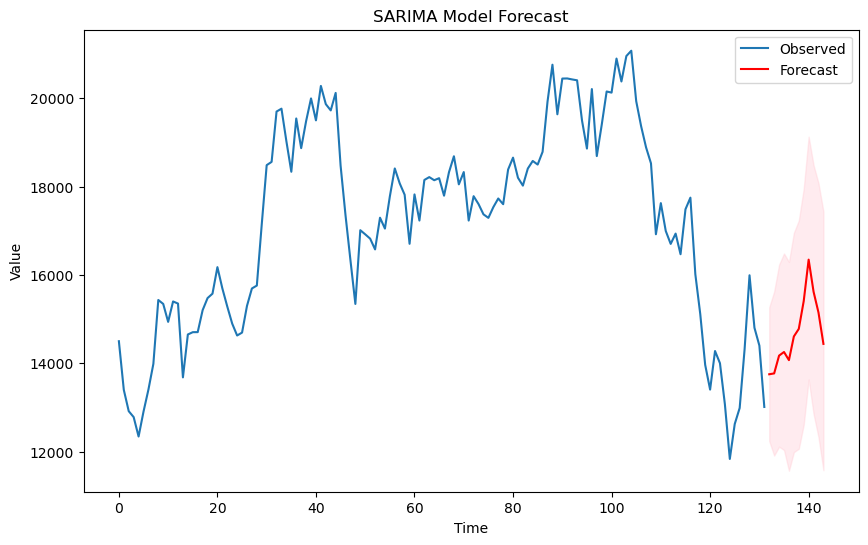

In [133]:
# 시각화
plt.figure(figsize=(10, 6))
plt.plot(cow_df.index, cow_df['1'], label='Observed')
plt.plot(forecast_index2, forecast_values2, label='Forecast', color='red')
plt.fill_between(forecast_index2, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.title('SARIMA Model Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()